In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 1s 0us/step


In [3]:
def prepare_image(file):
    img_path = 'MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

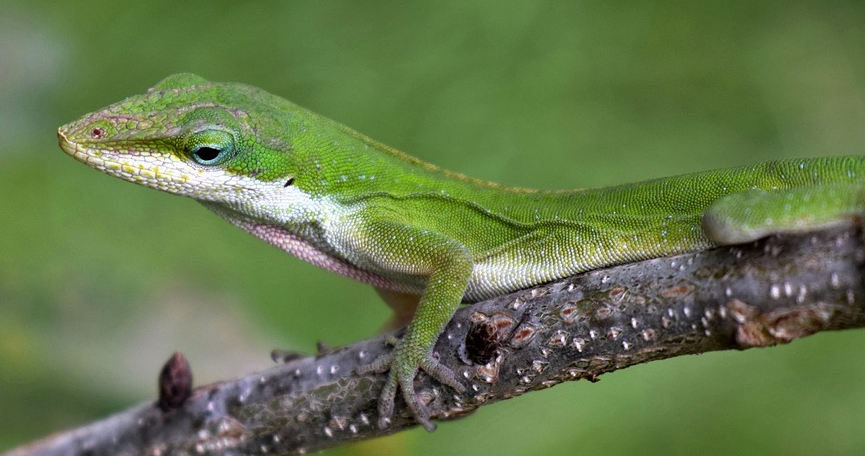

In [5]:
from IPython.display import Image
Image(filename='MobileNet-samples/1.PNG', width=300,height=200) 

In [7]:
preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01682714', 'American_chameleon', 0.58431494),
  ('n01693334', 'green_lizard', 0.27855736),
  ('n01687978', 'agama', 0.13019465),
  ('n01689811', 'alligator_lizard', 0.0047072833),
  ('n01688243', 'frilled_lizard', 0.001617669)]]

In [8]:
Image(filename='data/MobileNet-samples/2.PNG', width=300,height=200)

FileNotFoundError: [Errno 2] No such file or directory: 'data/MobileNet-samples/2.PNG'

In [9]:
preprocessed_image = prepare_image('2.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)

In [10]:
results

[[('n07920052', 'espresso', 0.9867621),
  ('n07930864', 'cup', 0.006894743),
  ('n07932039', 'eggnog', 0.0028749623),
  ('n03063599', 'coffee_mug', 0.0021079541),
  ('n04597913', 'wooden_spoon', 0.0010108596)]]

In [11]:
Image(filename='data/MobileNet-samples/3.PNG', width=300,height=200)

FileNotFoundError: [Errno 2] No such file or directory: 'data/MobileNet-samples/3.PNG'

In [12]:
preprocessed_image = prepare_image('3.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07745940', 'strawberry', 0.99998987),
  ('n07749582', 'lemon', 2.4314159e-06),
  ('n07747607', 'orange', 1.7603385e-06),
  ('n07768694', 'pomegranate', 1.5602117e-06),
  ('n07753275', 'pineapple', 8.5767095e-07)]]

In [13]:
# Organize data into train, valid, test dirs
os.chdir('Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [15]:
train_path = 'D:/Keras_TensorFlow/Sign-Language-Digits-Dataset/train'
valid_path = 'D:/Keras_TensorFlow/Sign-Language-Digits-Dataset/valid'
test_path = 'D:/Keras_TensorFlow/Sign-Language-Digits-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [16]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [17]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [18]:
x = mobile.layers[-6].output #gets all the layers up to the 6th to last one
output = Dense(units=10,activation='softmax')(x)

In [21]:
model = Model(inputs=mobile.input, outputs=output)

In [24]:
for layer in model.layers[:-23]: #this freezes all layers before the last 23 layers
    layer.trainable = False

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [26]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches),
    epochs=1, # I changed this to 1 from 10 to save time it will lower acc
    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 30 steps
172/172 - 138s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.5931 - val_accuracy: 0.8400


In [29]:
test_labels = test_batches.classes

In [30]:
predictions = model.predict(x=test_batches, verbose=0)

In [31]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [32]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 1 3 0 1 0 0 0 0]
 [0 0 0 0 3 0 2 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 1 0 0 0 0 0 1 3 0]
 [0 0 1 0 0 0 0 0 0 4]]


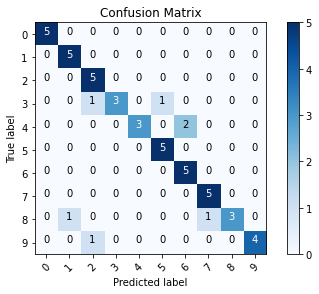

In [34]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')